<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/LSPD_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.4 MB 4.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Importing the Dataset & Exploring it

In [ ]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: LSPD.TO
You entered LSPD.TO, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
743,2022-03-01,33.410000,34.590000,32.169998,32.619999,929200,0,0
744,2022-03-02,33.000000,33.099998,31.129999,32.669998,976200,0,0
745,2022-03-03,33.000000,33.000000,30.950001,31.150000,1075400,0,0
746,2022-03-04,31.000000,31.600000,28.290001,28.580000,1855400,0,0
747,2022-03-07,28.510000,29.090000,26.379999,26.770000,1411900,0,0
748,2022-03-08,26.670000,28.850000,25.750000,27.780001,1431400,0,0
749,2022-03-09,29.000000,30.010000,28.590000,29.959999,1096500,0,0
750,2022-03-10,29.030001,29.440001,28.020000,28.950001,788100,0,0
751,2022-03-11,29.900000,29.900000,26.770000,26.870001,1088800,0,0
752,2022-03-14,26.950001,27.000000,25.330000,25.520000,473509,0,0


In [ ]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,753.000000,753.000000,753.000000,753.000000,7.530000e+02,753.0,753.0
mean,56.527610,57.898752,54.983054,56.459628,6.532820e+05,0.0,0.0
std,33.053677,33.705473,32.429116,33.106232,5.283909e+05,0.0,0.0
min,11.860000,13.690000,10.500000,12.000000,2.070000e+04,0.0,0.0
25%,33.480000,34.029999,32.549999,33.480000,3.245000e+05,0.0,0.0
50%,41.630001,42.759998,40.500000,41.540001,5.399000e+05,0.0,0.0
75%,83.889999,86.120003,81.190002,83.839996,8.638000e+05,0.0,0.0
max,160.940002,165.869995,157.130005,158.929993,6.905100e+06,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [ ]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [ ]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [ ]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [ ]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [ ]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [ ]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 2)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [ ]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
748,2022-03-08,27.780001
749,2022-03-09,29.959999
750,2022-03-10,28.950001
751,2022-03-11,26.870001
752,2022-03-14,25.520000


## Creating Facebook Prophet Model

In [ ]:
m=Prophet(yearly_seasonality=True)
m.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##Forecasting

In [ ]:
periods = 30
future=m.make_future_dataframe(periods)

In [ ]:
forecast=m.predict(future)

In [ ]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-03-14,38.273641,19.934082,44.452327,38.273641,38.273641,-6.322986,-6.322986,-6.322986,3.259123,3.259123,3.259123,-9.582109,-9.582109,-9.582109,0.0,0.0,0.0,31.950655
1,2019-03-15,38.215168,18.501191,43.154284,38.215168,38.215168,-7.500384,-7.500384,-7.500384,2.968181,2.968181,2.968181,-10.468566,-10.468566,-10.468566,0.0,0.0,0.0,30.714783
2,2019-03-18,38.039748,16.549772,41.768987,38.039748,38.039748,-9.700925,-9.700925,-9.700925,3.248724,3.248724,3.248724,-12.949649,-12.949649,-12.949649,0.0,0.0,0.0,28.338823
3,2019-03-19,37.981275,14.502237,39.878642,37.981275,37.981275,-10.430513,-10.430513,-10.430513,3.266257,3.266257,3.266257,-13.696770,-13.696770,-13.696770,0.0,0.0,0.0,27.550762
4,2019-03-20,37.922802,14.642407,39.400214,37.922802,37.922802,-11.318938,-11.318938,-11.318938,3.075089,3.075089,3.075089,-14.394027,-14.394027,-14.394027,0.0,0.0,0.0,26.603864
5,2019-03-21,37.864328,13.731628,39.329296,37.864328,37.864328,-11.776752,-11.776752,-11.776752,3.259123,3.259123,3.259123,-15.035875,-15.035875,-15.035875,0.0,0.0,0.0,26.087577
6,2019-03-22,37.805855,11.592450,37.537437,37.805855,37.805855,-12.648997,-12.648997,-12.648997,2.968181,2.968181,2.968181,-15.617179,-15.617179,-15.617179,0.0,0.0,0.0,25.156858
7,2019-03-25,37.630436,11.805128,35.764569,37.630436,37.630436,-13.706216,-13.706216,-13.706216,3.248724,3.248724,3.248724,-16.954940,-16.954940,-16.954940,0.0,0.0,0.0,23.924220
8,2019-03-26,37.571962,11.565510,35.270670,37.571962,37.571962,-13.988458,-13.988458,-13.988458,3.266257,3.266257,3.266257,-17.254715,-17.254715,-17.254715,0.0,0.0,0.0,23.583504
9,2019-03-27,37.513489,10.192736,35.071035,37.513489,37.513489,-14.403046,-14.403046,-14.403046,3.075089,3.075089,3.075089,-17.478135,-17.478135,-17.478135,0.0,0.0,0.0,23.110443


In [ ]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

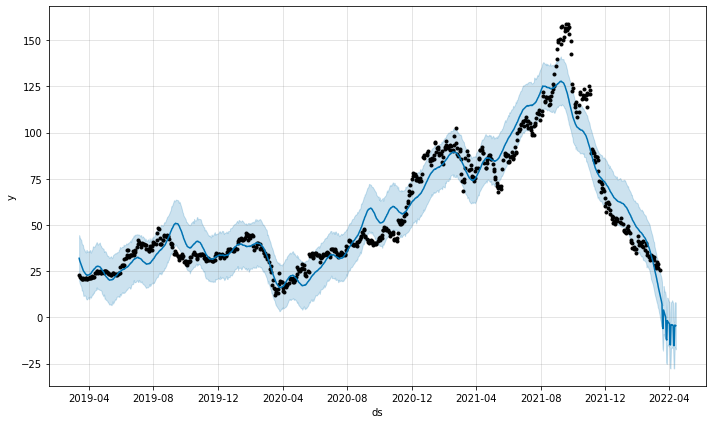

In [ ]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

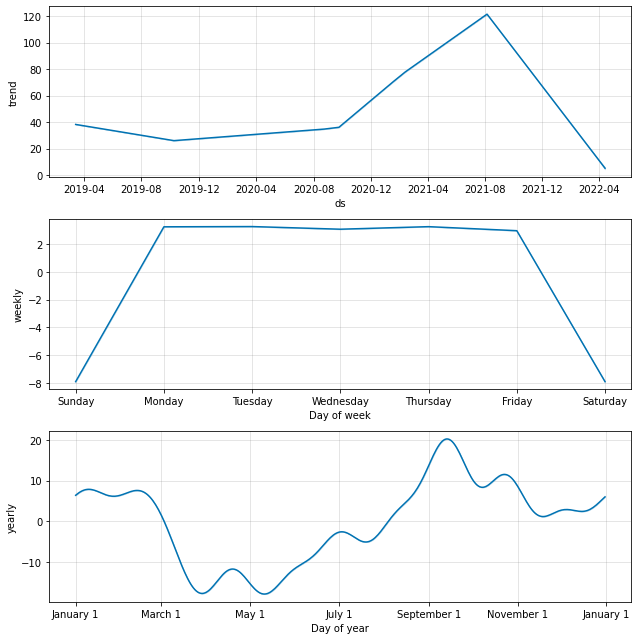

In [ ]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [ ]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>